In [142]:
import pandas as pd
import matplotlib.pyplot as plt
import xgboost
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression

In [8]:
df = pd.read_csv("data/recipes.csv")
df.head()

,RecipeId,Name,RecipeCategory,Calories,CholesterolContent,CarbohydrateContent,SugarContent,ProteinContent,RecipeServings,HighScore
0,46085,Crock Pot Baked Potato Soup,One Dish Meal,699.8,137.3,46.1,1.4,20.9,6.0,1.0
1,93832,Frittata Di Spaghetti (spaghetti Frittata),Breakfast,297.1,191.8,11.7,0.7,12.2,8.0,1.0
2,36034,Berries With Italian Cream,Dessert,131.9,23.3,10.3,4.4,9.1,6.0,0.0
3,329988,Pork Tenderloin Medallions With Fresh Figs,< 15 Mins,203.0,74.8,1.5,0.6,23.3,4.0,1.0
4,59886,Kaseropita (Tiropita Using Kaseri Cheese),Savory Pies,261.6,103.6,20.9,0.2,6.7,15.0,1.0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43092 entries, 0 to 43091
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   RecipeId             43092 non-null  int64  
 1   Name                 43092 non-null  object 
 2   RecipeCategory       43052 non-null  object 
 3   Calories             43092 non-null  float64
 4   CholesterolContent   43092 non-null  float64
 5   CarbohydrateContent  43092 non-null  float64
 6   SugarContent         43092 non-null  float64
 7   ProteinContent       43092 non-null  float64
 8   RecipeServings       43092 non-null  float64
 9   HighScore            43092 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 3.3+ MB


- There are total 43092 entries and 10 columns
- Name and RecipeCategory are object type i.e they are categorical column
- We can see that there are no missing values as non-null count is same

In [10]:
df.describe()

,RecipeId,Calories,CholesterolContent,CarbohydrateContent,SugarContent,ProteinContent,RecipeServings,HighScore
count,43092.000000,43092.000000,43092.000000,43092.000000,43092.000000,43092.000000,43092.000000,43092.000000
mean,224707.928154,353.297587,69.475757,32.844187,12.206600,15.773125,9.517521,0.645735
std,141980.914350,405.065683,112.422309,46.428258,28.304371,21.588594,224.022873,0.478296
min,38.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,102616.750000,164.800000,4.500000,11.600000,2.200000,3.400000,4.000000,0.000000
50%,212333.000000,284.100000,40.700000,25.400000,5.500000,8.800000,6.000000,1.000000
75%,336736.250000,446.725000,95.900000,43.400000,14.100000,24.300000,8.000000,1.000000
max,540876.000000,30933.400000,9167.200000,3564.400000,2566.800000,1420.800000,32767.000000,1.000000


- By seeing this we can get an idea few columns vary in scale
- As each column count is equal to length we can get an idea that there are no missing values

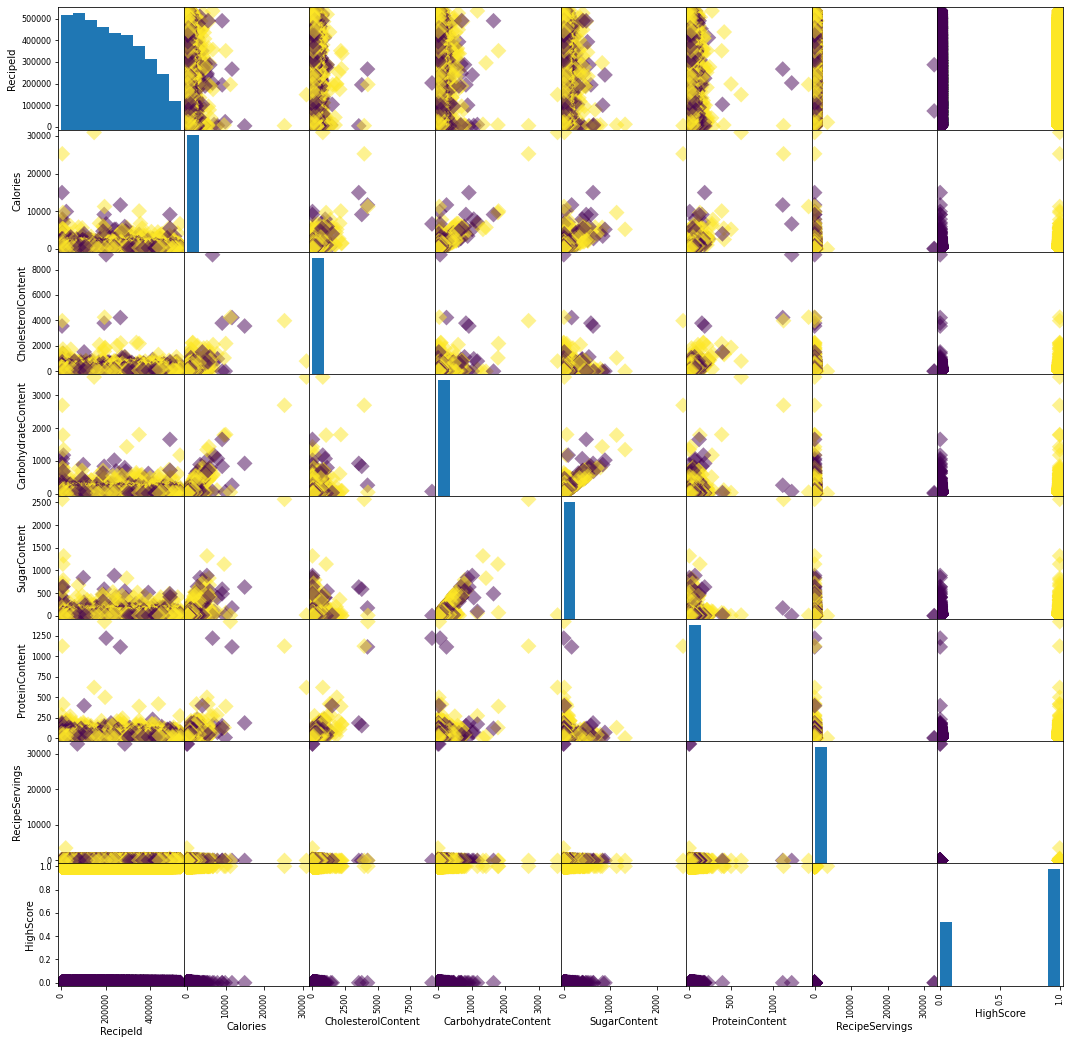

In [11]:
pd.plotting.scatter_matrix(df, c=df.HighScore, s=125, figsize=[18,18], marker='D')
plt.show()

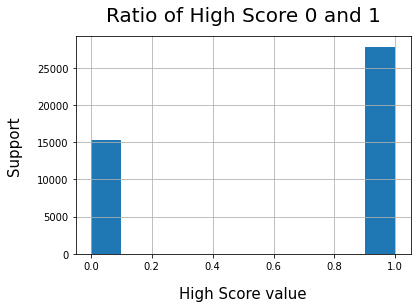

1.0    27826
0.0    15266
Name: HighScore, dtype: int64

In [157]:
df.HighScore.hist()
plt.xlabel('High Score value', labelpad=15, fontsize=15)
plt.ylabel('Support', labelpad=15, fontsize=15)
plt.title('Ratio of High Score 0 and 1', pad=15, fontsize=20)
plt.show()
df.HighScore.value_counts()

- Recipes having low-score (0) are almost 35% 
- Recipes of high-score (1) are almost 65%
- This can pose the problem of imbalanced data

In [13]:
pop_recipe_categ_counts = df[df.HighScore==1].RecipeCategory.value_counts()
pop_recipe_categ_counts

Dessert               2742
Lunch/Snacks          2148
One Dish Meal         1649
Vegetable             1630
Beverages             1307
                      ... 
No Shell Fish            1
Sudanese                 1
Pennsylvania Dutch       1
Welsh                    1
Belgian                  1
Name: RecipeCategory, Length: 235, dtype: int64

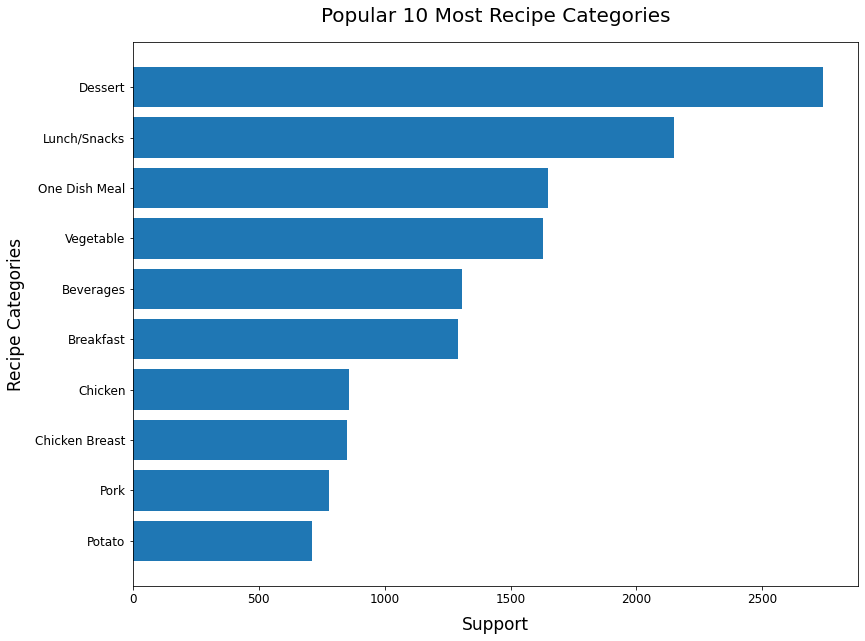

In [14]:
plt.figure(figsize=(13,10))
plt.barh(pop_recipe_categ_counts[:10].index[::-1], pop_recipe_categ_counts[:10][::-1].values)
plt.xticks(fontsize=12)
plt.xlabel('Support', fontsize=17, labelpad=10)
plt.yticks(fontsize=12)
plt.ylabel('Recipe Categories', fontsize=17, labelpad=10)
plt.title('Popular 10 Most Recipe Categories', fontsize=20, pad=20)
plt.show()

These are the 10 most popular recipe categories
- Dessert seems to be liked more

In [15]:
unpop_recipe_categ_counts = df[df.HighScore==0].RecipeCategory.value_counts()
unpop_recipe_categ_counts

Dessert          1469
One Dish Meal    1246
Lunch/Snacks     1123
Vegetable         867
Breakfast         677
                 ... 
Moose               1
Peanut Butter       1
Ice Cream           1
Swedish             1
Pakistani           1
Name: RecipeCategory, Length: 221, dtype: int64

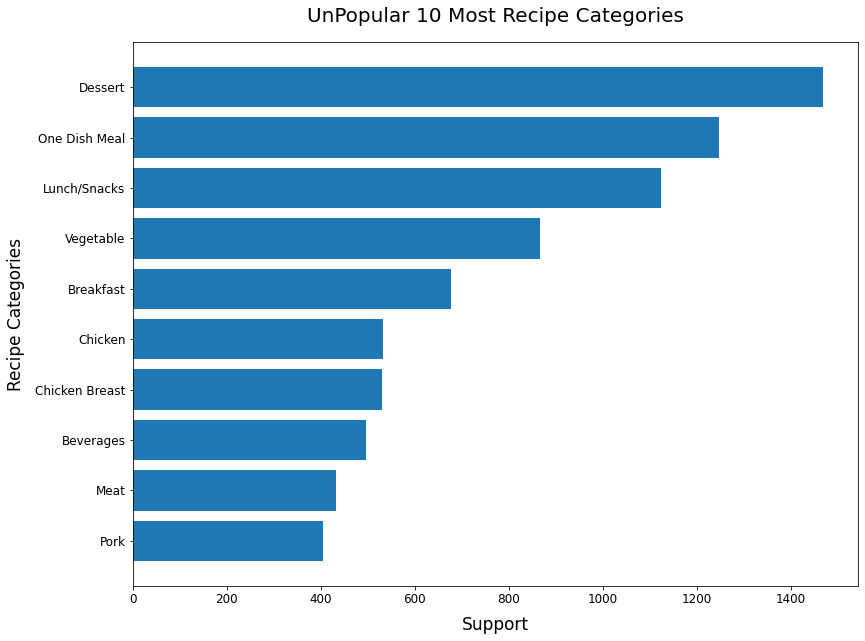

In [16]:
plt.figure(figsize=(13,10))
plt.barh(unpop_recipe_categ_counts[:10].index[::-1], unpop_recipe_categ_counts[:10][::-1].values)
plt.xticks(fontsize=12)
plt.xlabel('Support', fontsize=17, labelpad=10)
plt.yticks(fontsize=12)
plt.ylabel('Recipe Categories', fontsize=17, labelpad=10)
plt.title('UnPopular 10 Most Recipe Categories', fontsize=20, pad=20)
plt.show()

Both Barplots of popular and unpopular recipe categories are almost same where they are varying in position but all 10 most popular recipe categories are also in 10 most unpopular, hence one cannot rely on just recipe categories for recommendation with a mind 'Who doesn't like dessert?' because data analysis tells us that such assumptions can backfire

In [17]:
pd.options.display.max_rows = 1000  # Change this option if you wanna see all the categories and their counts
popular_recipes_counts = df[df.HighScore==1].Name.value_counts()
popular_recipes_counts

Broccoli Salad                           10
Sweet Potato Casserole                   10
Chicken Cacciatore                       10
Sloppy Joes                               9
Mexican Lasagna                           9
                                         ..
Pickled Carrots                           1
Oatmeal Chocolate Chip Raisin Cookies     1
Appled Chops with Stuffing                1
Tomatoes Stuffed With Rice                1
Skinny Green Chili Chicken                1
Name: Name, Length: 26984, dtype: int64

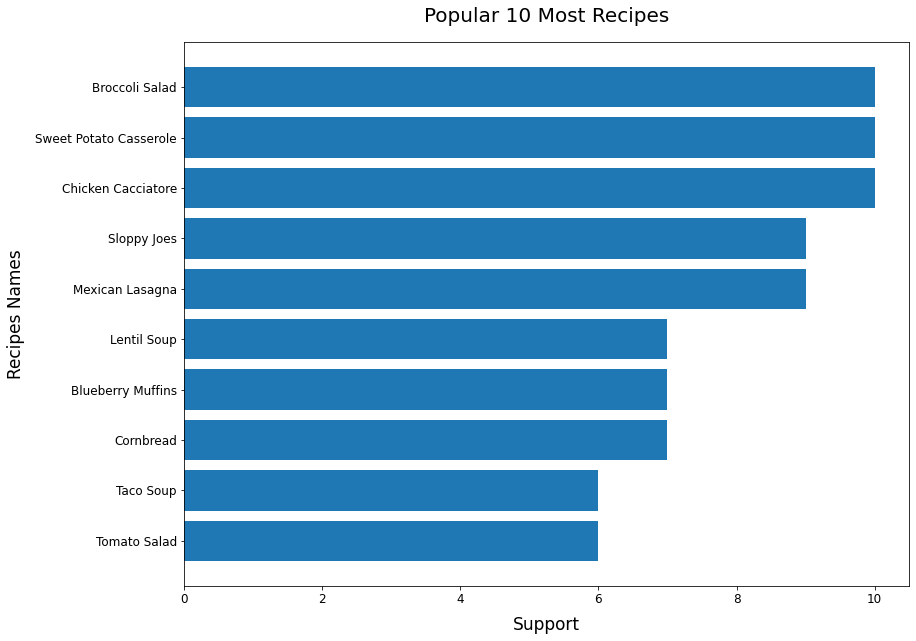

In [148]:
plt.figure(figsize=(13,10))
plt.barh(popular_recipes_counts[:10].index[::-1], popular_recipes_counts[:10][::-1].values)
plt.xticks(fontsize=12)
plt.xlabel('Support', fontsize=17, labelpad=10)
plt.yticks(fontsize=12)
plt.ylabel('Recipes Names', fontsize=17, labelpad=10)
plt.title('Popular 10 Most Recipes', fontsize=20, pad=20)
plt.savefig('popular-10-recipes.jpg')
plt.show()

In [19]:
unpopular_recipes_counts = df[df.HighScore==0].Name.value_counts()
unpopular_recipes_counts

Macaroni and Cheese                               6
Greek Pasta Salad                                 5
Hummus                                            5
Chicken Cacciatore                                5
Apple Crisp                                       5
                                                 ..
Cherry Tomato Meatballs                           1
Baked Pasta With Sausage, Tomatoes, and Cheese    1
Fried Cabbage                                     1
Best Vegetable Chowder                            1
Slow Cooker Shanks                                1
Name: Name, Length: 14912, dtype: int64

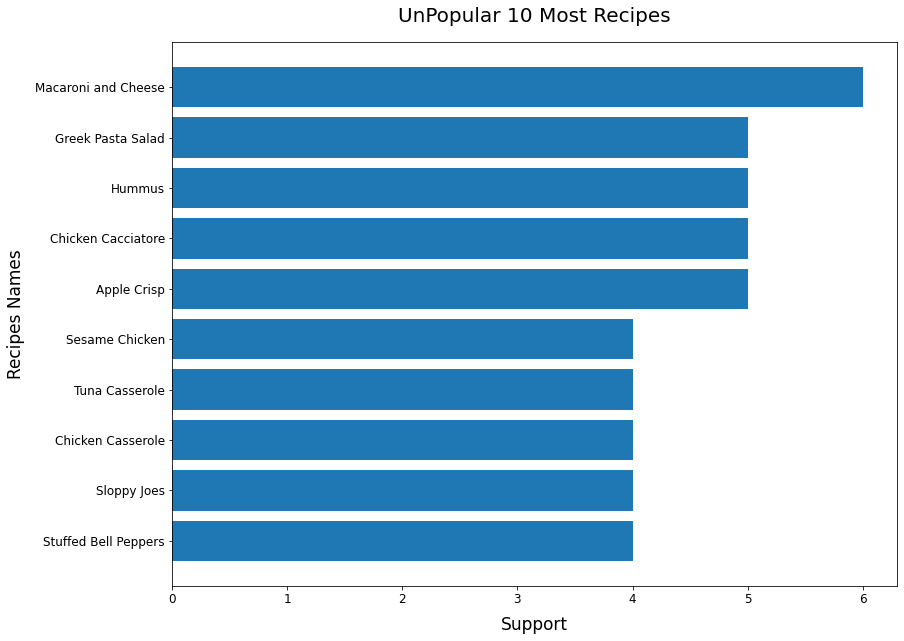

In [20]:
plt.figure(figsize=(13,10))
plt.barh(unpopular_recipes_counts[:10].index[::-1], unpopular_recipes_counts[:10][::-1].values)
plt.xticks(fontsize=12)
plt.xlabel('Support', fontsize=17, labelpad=10)
plt.yticks(fontsize=12)
plt.ylabel('Recipes Names', fontsize=17, labelpad=10)
plt.title('UnPopular 10 Most Recipes', fontsize=20, pad=20)
plt.show()

In [21]:
df[df.HighScore==0][df.RecipeCategory=='Dessert'].Name.value_counts()

<ipython-input-21-9880837b963d>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df.HighScore==0][df.RecipeCategory=='Dessert'].Name.value_counts()


Apple Crisp                                      5
Easy Peach Cobbler                               2
Peach Crumble                                    2
Fresh Peach Cobbler                              2
Banana Cake                                      2
                                                ..
The Cake Doctor's Red Velvet Cake                1
Berry Pudding Cake                               1
Spice Cake With Caramel Frosting                 1
Baked Mochi                                      1
Easy Hummingbird Cake (From a Boxed Cake Mix)    1
Name: Name, Length: 1446, dtype: int64

In [22]:
df[df.HighScore==1][df.RecipeCategory=='Dessert'].Name.value_counts()

<ipython-input-22-e9e78d267c39>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df.HighScore==1][df.RecipeCategory=='Dessert'].Name.value_counts()


Apple Crisp                                 5
Blueberry Cobbler                           3
Monster Cookies                             3
Pumpkin Cake                                3
Gingerbread Cake                            3
                                           ..
Delicious and Healthy Chocolate Pudding     1
Golden Pears                                1
Deluxe Lemon Bars                           1
Mexican Hot Fudge Sundae                    1
Strawberry Swirl Cream Cheese Pound Cake    1
Name: Name, Length: 2667, dtype: int64

We can see that Apple Crisp is a Dessert and its popular as well as unpopular, this proves our analysis

In [129]:
df_2 = df.copy()
df_2['Name'] = df_2['Name'].astype('category')  # for speed
df_2['RecipeCategory'] = df_2['RecipeCategory'].astype('category')  # for speed

# Label Encoding
df_2['Name'] = df_2['Name'].cat.codes
df_2['RecipeCategory'] = df_2['RecipeCategory'].cat.codes

# # Replacing values
# name = df_2['Name'].cat.categories.tolist()
# recipe_category = df_2['RecipeCategory'].cat.categories.tolist()

# replace = {'Name': {k: v for k,v in zip(name, list(range(len(name))))}, 
#            'RecipeCategory': {k: v for k,v in zip(recipe_category, list(range(len(recipe_category))))}}

# df_2.replace(replace, inplace=True)

df_2.head()

,RecipeId,Name,RecipeCategory,Calories,CholesterolContent,CarbohydrateContent,SugarContent,ProteinContent,RecipeServings,HighScore
0,46085,11903,144,699.8,137.3,46.1,1.4,20.9,6.0,1.0
1,93832,15748,24,297.1,191.8,11.7,0.7,12.2,8.0,1.0
2,36034,3954,63,131.9,23.3,10.3,4.4,9.1,6.0,0.0
3,329988,28917,0,203.0,74.8,1.5,0.6,23.3,4.0,1.0
4,59886,20791,185,261.6,103.6,20.9,0.2,6.7,15.0,1.0


In [130]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43092 entries, 0 to 43091
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   RecipeId             43092 non-null  int64  
 1   Name                 43092 non-null  int32  
 2   RecipeCategory       43092 non-null  int16  
 3   Calories             43092 non-null  float64
 4   CholesterolContent   43092 non-null  float64
 5   CarbohydrateContent  43092 non-null  float64
 6   SugarContent         43092 non-null  float64
 7   ProteinContent       43092 non-null  float64
 8   RecipeServings       43092 non-null  float64
 9   HighScore            43092 non-null  float64
dtypes: float64(7), int16(1), int32(1), int64(1)
memory usage: 2.9 MB


In [131]:
# Defining our features
features = df_2.drop('HighScore', axis=1)  

# Defining our labels
labels = df_2['HighScore']

# # Scaling features
# scaler = StandardScaler()  
# features = scaler.fit_transform(features)  

# Train Test split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, stratify=labels)

In [132]:
total_majority_class = len(df[df['HighScore']==0])
total_minority_class = len(df[df['HighScore']==1])
print(total_majority_class, total_minority_class)

scale_pos_weight = total_majority_class / total_minority_class
print("scale_pos_weight should be", scale_pos_weight)

15266 27826
scale_pos_weight should be 0.548623589448717


In [133]:
xgb = xgboost.XGBClassifier(scale_pos_weight=scale_pos_weight)
xgb.fit(X_train, y_train)

/home/ammar/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:50:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.548623589448717,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [134]:
print(accuracy_score(y_test, xgb.predict(X_test)))

0.5538283062645012


In [135]:
print( classification_report(y_test, xgb.predict(X_test)) )

              precision    recall  f1-score   support

         0.0       0.40      0.50      0.44      1527
         1.0       0.68      0.58      0.63      2783

    accuracy                           0.55      4310
   macro avg       0.54      0.54      0.54      4310
weighted avg       0.58      0.55      0.56      4310



In [136]:
zero_only = df_2[df_2['HighScore']==0]
one_only = df_2[df_2['HighScore']==1]

one_only = one_only.sample(n=len(zero_only), random_state=10)

df_balanced = pd.concat([zero_only, one_only])
# df_balanced = pd.get_dummies(df_balanced)
features_balanced = df_balanced.drop('HighScore', axis=1)  

# Defining our labels
labels_balanced = df_balanced['HighScore']


# Train Test split
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(features_balanced, labels_balanced, test_size=0.1, stratify=labels_balanced)    

xgb_bal = xgboost.XGBClassifier()
xgb_bal.fit(X_train, y_train)

/home/ammar/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:50:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [137]:
print(accuracy_score(y_test_bal, xgb_bal.predict(X_test_bal)))
print(accuracy_score(y_test, xgb_bal.predict(X_test)))
print(roc_auc_score(y_test, xgb_bal.predict(X_test)))

0.6267190569744597
0.625522041763341
0.5091959532581694


In [140]:
print( classification_report(y_test_bal, xgb_bal.predict(X_test_bal)) )

              precision    recall  f1-score   support

         0.0       0.90      0.29      0.43      1527
         1.0       0.58      0.97      0.72      1527

    accuracy                           0.63      3054
   macro avg       0.74      0.63      0.58      3054
weighted avg       0.74      0.63      0.58      3054



In [141]:
print( classification_report(y_test, xgb_bal.predict(X_test)) )

              precision    recall  f1-score   support

         0.0       0.40      0.11      0.17      1527
         1.0       0.65      0.91      0.76      2783

    accuracy                           0.63      4310
   macro avg       0.52      0.51      0.47      4310
weighted avg       0.56      0.63      0.55      4310



In [145]:
logistic = LogisticRegression()
logistic.fit(X_train_bal, y_train_bal)

print(accuracy_score(y_test_bal, logistic.predict(X_test_bal)))
print(classification_report(y_test_bal, logistic.predict(X_test_bal)))

0.5366732154551408
              precision    recall  f1-score   support

         0.0       0.54      0.47      0.50      1527
         1.0       0.53      0.60      0.57      1527

    accuracy                           0.54      3054
   macro avg       0.54      0.54      0.53      3054
weighted avg       0.54      0.54      0.53      3054

